# Tech Challenge - Fase 1

## Grupo 22

## Integrantes do Grupo
* Matheus Alves da Silva - matheusa761@gmail.com
* Alexandre Pantalena Yoshimatsu - alexandre.yoshimatsu@virgo.inc

# O Problema

Você é um profissional encarregado de desenvolver um modelo preditivo de regressão para prever o valor dos custos médicos individuais cobrados pelo seguro de saúde. 

A base de dados para este desafio pode ser algo como no exemplo a seguir:

<code>
idade,gênero,imc,filhos,fumante,região,encargos
</code>

Você precisa apenas alimentar ela com mais informações ou utilizar uma outra de sua preferência.

## Tarefas

### Exploração de Dados

Iniciando com os imports

In [33]:
#import's de bibliotecas necessárias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(42)

# Configurações para melhorar visualização dos plots
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [34]:
# Carregando os dados
dataset = pd.read_csv("encargos.csv")

# Definindo nossa coluna target
target_column = 'encargos'

# Visualizando os dados
dataset.head()

,idade,gênero,imc,filhos,fumante,região,encargos
0,19,feminino,27.900,0,sim,sudoeste,16884.92400
1,18,masculino,33.770,1,não,sudeste,1725.55230
2,28,masculino,33.000,3,não,sudeste,4449.46200
3,33,masculino,22.705,0,não,noroeste,21984.47061
4,32,masculino,28.880,0,não,noroeste,3866.85520


In [35]:
#  Linhas e colunas
dataset.shape

(1338, 7)

In [36]:
# Caracteristicas dos dados
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   idade     1338 non-null   int64  
 1   gênero    1338 non-null   object 
 2   imc       1338 non-null   float64
 3   filhos    1338 non-null   int64  
 4   fumante   1338 non-null   object 
 5   região    1338 non-null   object 
 6   encargos  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [37]:
dataset.describe()

,idade,imc,filhos,encargos
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Vamos procurar se temos valores nulos no nosso dataset?

In [38]:
# Verificando nulos
dataset.isnull().sum()

idade       0
gênero      0
imc         0
filhos      0
fumante     0
região      0
encargos    0
dtype: int64

### Verificando quantidade de dados por categoria

<Figure size 600x600 with 0 Axes>

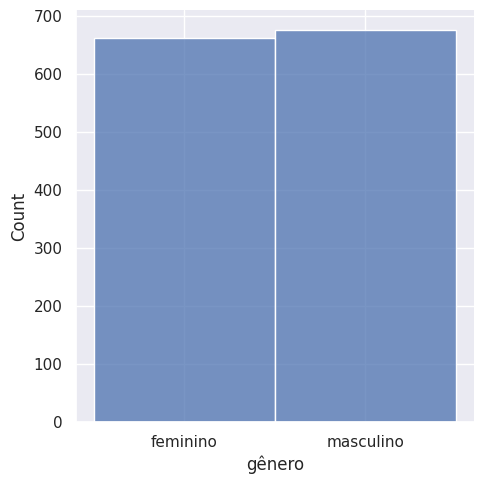

In [39]:
#Distribuição por gênero
sns.set()
plt.figure(figsize=(6,6))
sns.displot(dataset['gênero'])
plt.show()

<Figure size 600x600 with 0 Axes>

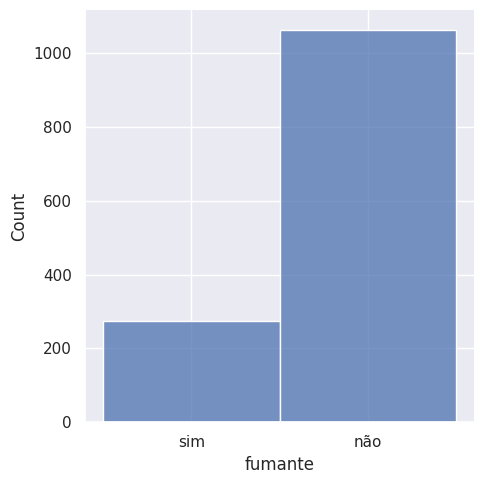

In [40]:
#Distribuição pela categoria fumante
sns.set()
plt.figure(figsize=(6,6))
sns.displot(dataset['fumante'])
plt.show()

<Figure size 600x600 with 0 Axes>

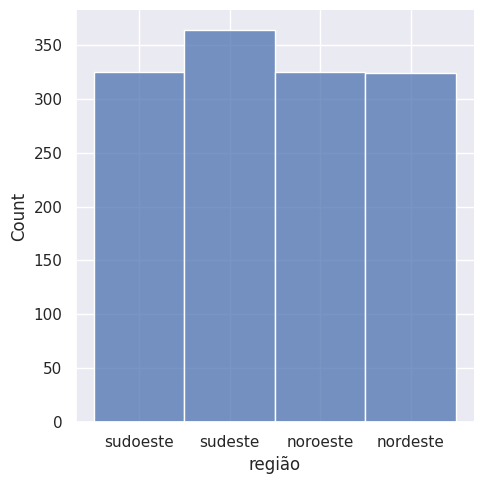

In [41]:
#Distribuição por regiao
sns.set()
plt.figure(figsize=(6,6))
sns.displot(dataset['região'])
plt.show()

<Figure size 600x600 with 0 Axes>

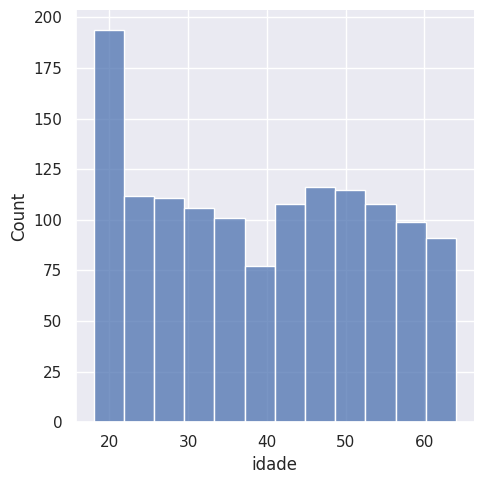

In [42]:
#Distribuição por idade
sns.set()
plt.figure(figsize=(6,6))
sns.displot(dataset['idade'])
plt.show()

### Analises

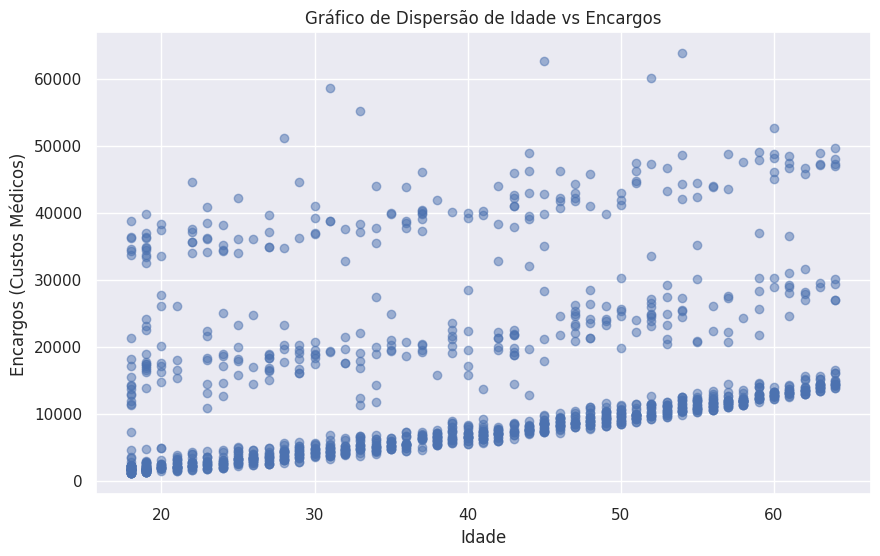

In [43]:
# Gráfico de Dispersão de Idade vs Encargos
plt.figure(figsize=(10, 6))
plt.scatter(dataset['idade'], dataset['encargos'], alpha=0.5)
plt.title('Gráfico de Dispersão de Idade vs Encargos')
plt.xlabel('Idade')
plt.ylabel('Encargos (Custos Médicos)')
plt.show()

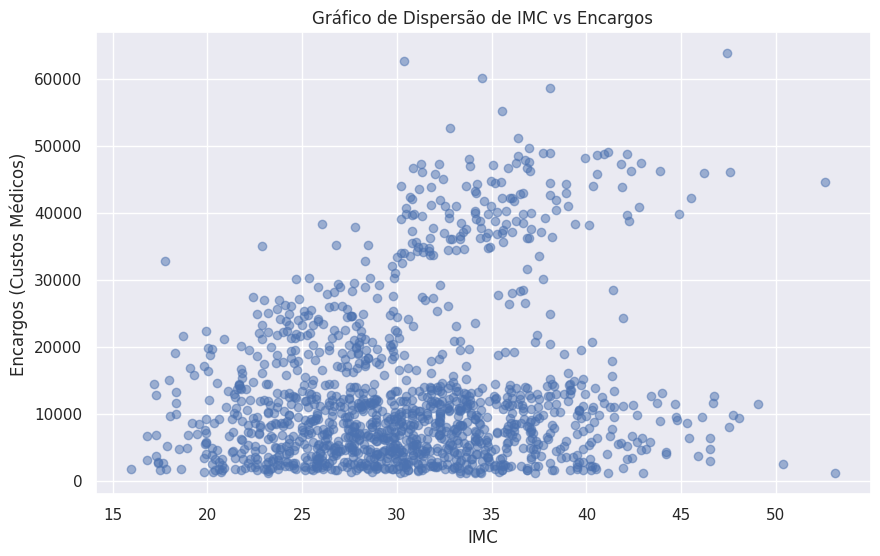

In [44]:
# Gráfico de Dispersão de IMC vs Encargos
plt.figure(figsize=(10, 6))
plt.scatter(dataset['imc'], dataset['encargos'], alpha=0.5)
plt.title('Gráfico de Dispersão de IMC vs Encargos')
plt.xlabel('IMC')
plt.ylabel('Encargos (Custos Médicos)')
plt.show()

<Axes: >

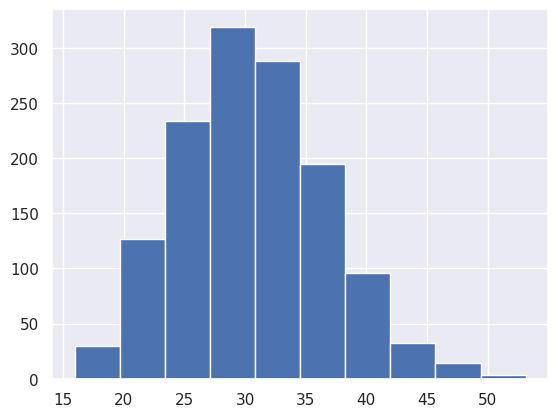

In [45]:
dataset["imc"].hist()

#### Classificando IMC com fim de uma analise mais aprofundada

In [46]:
dataset["imc_cat"] = np.ceil(dataset["imc"] / 1.5) # ceil para arredondar valores para cima
dataset["imc_cat"].where(dataset["imc"] < 30, 4.0, inplace=True)

In [47]:
dataset["imc_cat"] = pd.cut(dataset["imc"],
                               bins=[15, 20, 25, 30, np.inf],
                               labels=[1, 2, 3, 4])

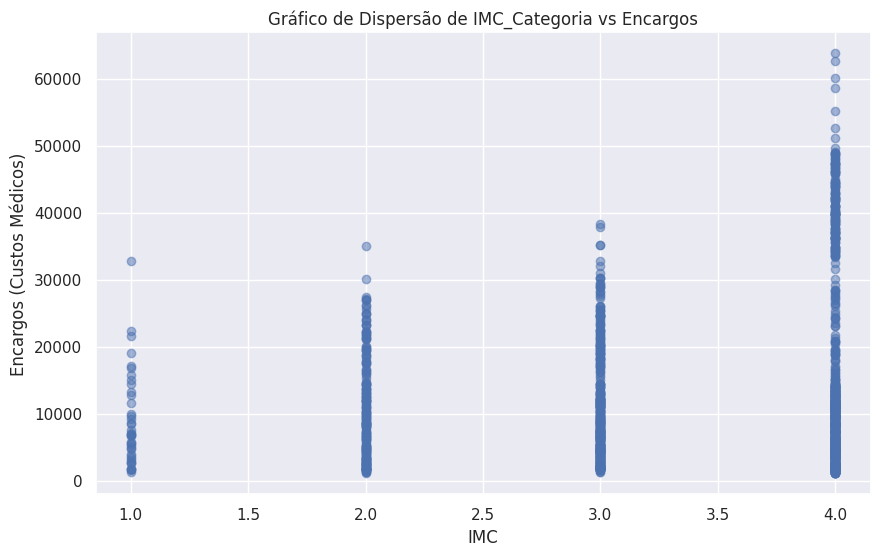

In [48]:
# Gráfico de Dispersão de Idade vs Encargos
plt.figure(figsize=(10, 6))
plt.scatter(dataset['imc_cat'], dataset['encargos'], alpha=0.5)
plt.title('Gráfico de Dispersão de IMC_Categoria vs Encargos')
plt.xlabel('IMC')
plt.ylabel('Encargos (Custos Médicos)')
plt.show()

<Figure size 1000x600 with 0 Axes>

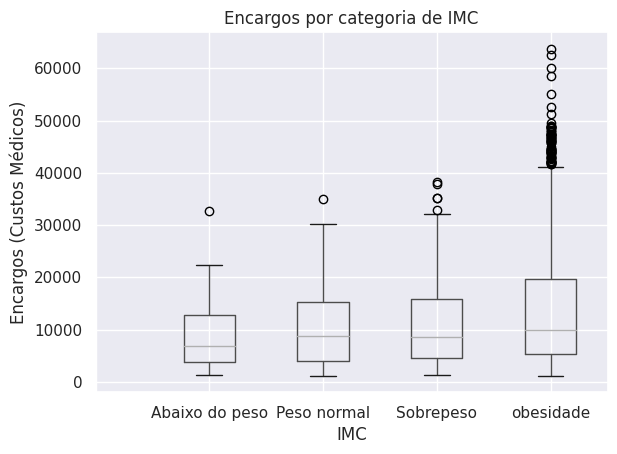

In [49]:
# Boxplot de Encargos por quantidade de filhos
plt.figure(figsize=(10, 6))
dataset.boxplot(column='encargos', by='imc_cat')
plt.title('Encargos por categoria de IMC')
plt.xlabel('IMC')
plt.ylabel('Encargos (Custos Médicos)')
plt.suptitle('')
# Substituindo as labels
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=['', 'Abaixo do peso', 'Peso normal', 'Sobrepeso', 'obesidade'])
plt.show()

In [50]:
print('''
    A mediana dos custos médicos parece aumentar conforme o IMC aumenta,
    especialmente notável na categoria "obesidade", onde a mediana é maior em
    comparação com as outras categorias.
''')
# ------------------------------------------------------------------------------
print('''
    As categorias "Peso normal" e "Sobrepeso" têm uma dispersão similar,
    enquanto a categoria "obesidade" tem uma caixa um pouco maior, indicando
    uma maior variabilidade nos encargos médicos.

''')
# ------------------------------------------------------------------------------
print('''
    Existem vários outliers, especialmente na categoria "obesidade", o que
    sugere que alguns indivíduos com obesidade têm encargos médicos
    significativamente maiores que o restante.

''')


    A mediana dos custos médicos parece aumentar conforme o IMC aumenta,
    especialmente notável na categoria "obesidade", onde a mediana é maior em
    comparação com as outras categorias.


    As categorias "Peso normal" e "Sobrepeso" têm uma dispersão similar,
    enquanto a categoria "obesidade" tem uma caixa um pouco maior, indicando
    uma maior variabilidade nos encargos médicos.



    Existem vários outliers, especialmente na categoria "obesidade", o que
    sugere que alguns indivíduos com obesidade têm encargos médicos
    significativamente maiores que o restante.




#### Analise para fumantes

In [51]:
print('''
    A mediana dos custos médicos para fumantes ("yes") é significativamente mais
  alta em comparação com os não fumantes ("no"). Isso sugere que, em média,
  fumantes têm encargos médicos maiores.

''')
# ------------------------------------------------------------------------------
print('''
    - A caixa para os fumantes é muito maior do que para os não fumantes,
   indicando uma maior dispersão (variabilidade) nos custos médicos entre
  os fumantes.

    - A caixa dos não fumantes é mais compacta, sugerindo que a maioria dos não
   fumantes tem custos médicos relativamente mais baixos e menos variáveis.

''')
# ------------------------------------------------------------------------------
print('''
    - Para os não fumantes, há muitos outliers, sugerindo que embora a maioria
   tenha custos médicos baixos, alguns indivíduos não fumantes enfrentam custos
   médicos significativamente maiores.

    - Para os fumantes, não há muitos outliers visíveis, mas a distribuição
    em si já é mais ampla, indicando que os altos custos são comuns entre os
    fumantes.

''')


    A mediana dos custos médicos para fumantes ("yes") é significativamente mais
  alta em comparação com os não fumantes ("no"). Isso sugere que, em média,
  fumantes têm encargos médicos maiores.



    - A caixa para os fumantes é muito maior do que para os não fumantes,
   indicando uma maior dispersão (variabilidade) nos custos médicos entre
  os fumantes.

    - A caixa dos não fumantes é mais compacta, sugerindo que a maioria dos não
   fumantes tem custos médicos relativamente mais baixos e menos variáveis.



    - Para os não fumantes, há muitos outliers, sugerindo que embora a maioria
   tenha custos médicos baixos, alguns indivíduos não fumantes enfrentam custos
   médicos significativamente maiores.

    - Para os fumantes, não há muitos outliers visíveis, mas a distribuição
    em si já é mais ampla, indicando que os altos custos são comuns entre os
    fumantes.




<Figure size 1000x600 with 0 Axes>

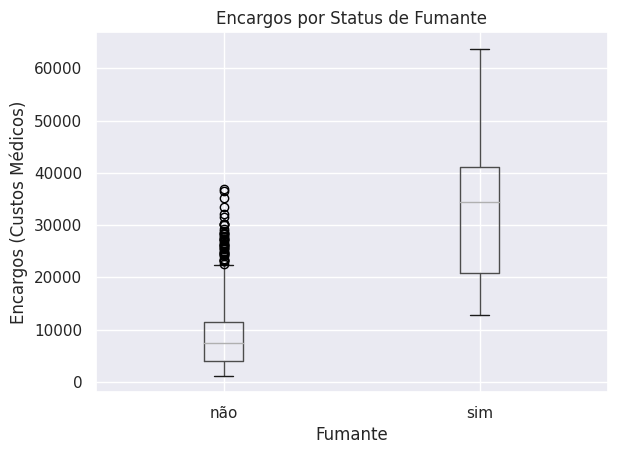

In [52]:
# Boxplot de Encargos por quantidade de filhos
plt.figure(figsize=(10, 6))
dataset.boxplot(column='encargos', by='fumante')
plt.title('Encargos por Status de Fumante')
plt.xlabel('Fumante')
plt.ylabel('Encargos (Custos Médicos)')
plt.suptitle('')
plt.show()

#### Convertendo variáveis categoricas

In [53]:
#Converting Categorical Columns into Numerical Columns

dataset.replace({'gênero':{'feminino':0, 'masculino':1}}, inplace=True)

dataset.replace({'fumante':{'não':0, 'sim':1}}, inplace=True)

dataset.replace({'região':{'sudeste':0, 'sudoeste':1, 'nordeste':2, 'noroeste':3}}, inplace=True)

#### Buscando correlações

In [54]:
corr_matrix = dataset.corr()

/tmp/ipykernel_473564/4260077771.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = dataset.corr()


In [55]:
corr_matrix["encargos"].sort_values(ascending=False)

encargos    1.000000
fumante     0.787251
idade       0.299008
imc         0.198341
filhos      0.067998
gênero      0.057292
região     -0.056993
Name: encargos, dtype: float64

/tmp/ipykernel_473564/1564127366.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.triu(np.ones_like(dataset.corr(), dtype=bool))
/tmp/ipykernel_473564/1564127366.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(dataset.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')


Text(0.5, 1.0, 'Mapa de calor de correlação triangular')

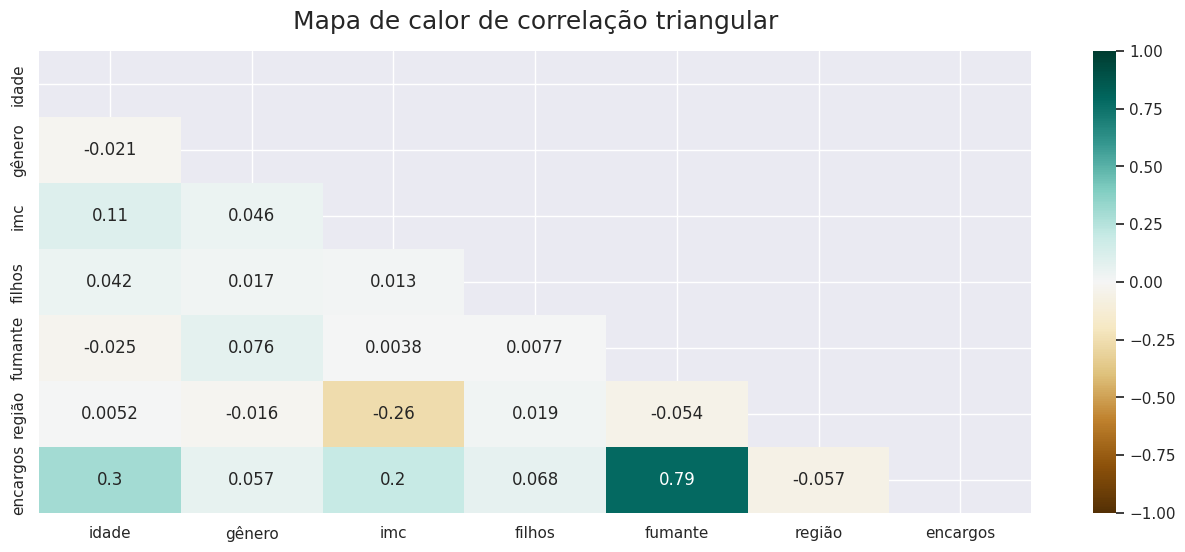

In [56]:
plt.figure(figsize=(16, 6))
# define a máscara para definir os valores no triângulo superior como True
mask = np.triu(np.ones_like(dataset.corr(), dtype=bool))
heatmap = sns.heatmap(dataset.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Mapa de calor de correlação triangular', fontdict={'fontsize':18}, pad=16)

In [57]:
print('''
1. Correlação entre fumante e encargos (0.79):

Alta Correlação Positiva: Há uma correlação positiva forte entre o status de
fumante e os encargos médicos, indicando que ser fumante está fortemente
associado a custos médicos mais elevados. Isso é consistente com o que foi
observado anteriormente no boxplot.''')
# ------------------------------------------------------------------------------
print('''
2. Correlação entre imc e encargos (0.2):

Correlação Moderada Positiva: Existe uma correlação moderada positiva entre o
IMC e os encargos médicos. Isso sugere que indivíduos com IMC mais alto tendem
a ter encargos médicos mais elevados, embora a correlação não seja tão forte
quanto a observada entre fumante e encargos.
''')
# ------------------------------------------------------------------------------
print('''
3. Correlação entre idade e encargos (0.3):

Correlação Moderada Positiva: A idade também tem uma correlação positiva
moderada com os encargos médicos. Isso sugere que, à medida que a idade aumenta,
os encargos médicos tendem a aumentar, possivelmente devido a problemas de
saúde relacionados à idade.
''')


1. Correlação entre fumante e encargos (0.79):

Alta Correlação Positiva: Há uma correlação positiva forte entre o status de
fumante e os encargos médicos, indicando que ser fumante está fortemente
associado a custos médicos mais elevados. Isso é consistente com o que foi
observado anteriormente no boxplot.

2. Correlação entre imc e encargos (0.2):

Correlação Moderada Positiva: Existe uma correlação moderada positiva entre o
IMC e os encargos médicos. Isso sugere que indivíduos com IMC mais alto tendem
a ter encargos médicos mais elevados, embora a correlação não seja tão forte
quanto a observada entre fumante e encargos.


3. Correlação entre idade e encargos (0.3):

Correlação Moderada Positiva: A idade também tem uma correlação positiva
moderada com os encargos médicos. Isso sugere que, à medida que a idade aumenta,
os encargos médicos tendem a aumentar, possivelmente devido a problemas de
saúde relacionados à idade.



In [58]:
dataset = pd.read_csv("encargos.csv")

### Pré Processamento de Dados

Vamos iniciar com o pré processamentos do nosso dataset, realizando as nossas padronizações e encodeds.

In [59]:
from sklearn.model_selection import train_test_split

# Obtendos nossas variáveis X e y
X = dataset.drop(target_column, axis=1)
y = dataset[target_column]

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

numeric_features, categorical_features

(['idade', 'imc', 'filhos'], ['gênero', 'fumante', 'região'])

Agora vamos splitar nossa base de treino e teste

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

E então podemos definir 2 pipelines para realizar as nossas transformações

In [61]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Tratamento para possíveis valores nulos e dimensionamento padronizado
numeric_transformer = Pipeline(steps=[
	('imputer', SimpleImputer(strategy='mean')),
	('scaler', StandardScaler())
])

# Tratamento para codificação de variáveis categóricas
categorical_transformer = Pipeline(steps=[
	('encoder', OneHotEncoder(drop='first'))
])

Combinando nossas transformações

In [62]:
preprocessor = ColumnTransformer(
	transformers=[
    	('num', numeric_transformer, numeric_features),
    	('cat', categorical_transformer, categorical_features)
	]
)

preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['idade', 'imc', 'filhos']),
                                ('cat',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(drop='first'))]),
                                 ['gênero', 'fumante', 'região'])])

Agora aplicaremos ao nosso dataset

In [63]:
X_train_processed = preprocessor.transform(X_train)

X_test_processed = preprocessor.transform(X_test)

In [64]:
preprocessor.get_feature_names_out()

array(['num__idade', 'num__imc', 'num__filhos', 'cat__gênero_masculino',
       'cat__fumante_sim', 'cat__região_noroeste', 'cat__região_sudeste',
       'cat__região_sudoeste'], dtype=object)

### Modelagem

Importando os nossos modelos que serão utilizados. Utilizaremos a validação cruzada e o tunning dos hyper parâmetros para obter a melhor configuração dos modelos.

In [65]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble._forest import RandomForestRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.metrics import make_scorer, mean_absolute_error, r2_score

# Definindo o número de kfolds com embaralhamento
folds = 5
kfold  = KFold(n_splits=folds, shuffle=True)

# Métrica de desempenho = melhor acurácia
# https://scikit-learn.org/stable/modules/model_evaluation.html
# gs_metric = make_scorer(mean_absolute_error, greater_is_better=False)
gs_metric = make_scorer(r2_score, greater_is_better=True)

# Controle de verbosidade
verbose_flag = 3

Configurando e avaliando o modelo de Regressão Linear

In [66]:
params = {"fit_intercept": [True, False],}

grid = GridSearchCV(estimator=LinearRegression(), 
                    param_grid=params,
                    scoring=gs_metric,
					return_train_score=True,
                    cv=folds, n_jobs=4, verbose=verbose_flag)

grid.fit(X_train_processed, y_train)

# Selecionando os melhores hiperparametros com base nos dados de treino
print(f'Best Parameters: {grid.best_params_}')
print(f'Best Cross-Validation Score: {grid.best_score_:.2f}')


# model_lr = LinearRegression(fit_intercept=True)
model_lr = grid.best_estimator_
model_lr

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Parameters: {'fit_intercept': True}
Best Cross-Validation Score: 0.73


LinearRegression()

Configurando e avaliando o modelo Lasso

In [67]:
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 
                    10.0, 20, 50, 100, 500, 1000 ]}

grid = GridSearchCV(estimator=Lasso(), 
                    param_grid=params,
                    scoring=gs_metric,
					return_train_score=True,
                    cv=folds, n_jobs=4, verbose=verbose_flag)

grid.fit(X_train_processed, y_train)

# Selecionando os melhores hiperparametros com base nos dados de treino
print(f'Best Parameters: {grid.best_params_}')
print(f'Best Cross-Validation Score: {grid.best_score_:.2f}')

# model_lasso = Lasso(alpha=10)
model_lasso = grid.best_estimator_
model_lasso

Fitting 5 folds for each of 28 candidates, totalling 140 fits
Best Parameters: {'alpha': 100}
Best Cross-Validation Score: 0.73


Lasso(alpha=100)

Configurando e avaliando o modelo Ridge

In [68]:
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 
                    10.0, 20, 50, 100, 500, 1000 ]}

grid = GridSearchCV(estimator=Ridge(), 
                    param_grid=params,
                    scoring=gs_metric,
					return_train_score=True,
                    cv=folds, n_jobs=4, verbose=verbose_flag)

grid.fit(X_train_processed, y_train)

# Selecionando os melhores hiperparametros com base nos dados de treino
print(f'Best Parameters: {grid.best_params_}')
print(f'Best Cross-Validation Score: {grid.best_score_:.2f}')

# model_ridge = Ridge(alpha=0.0001)
model_ridge = grid.best_estimator_
model_ridge

Fitting 5 folds for each of 28 candidates, totalling 140 fits
Best Parameters: {'alpha': 1.0}
Best Cross-Validation Score: 0.73


Ridge()

Configurando e avaliando o modelo Ridge

In [69]:
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 
                    10.0, 20, 50, 100, 500, 1000 ]}

grid = GridSearchCV(estimator=ElasticNet(), 
                    param_grid=params,
                    scoring=gs_metric,
					return_train_score=True,
                    cv=folds, n_jobs=4, verbose=verbose_flag)

grid.fit(X_train_processed, y_train)

# Selecionando os melhores hiperparametros com base nos dados de treino
print(f'Best Parameters: {grid.best_params_}')
print(f'Best Cross-Validation Score: {grid.best_score_:.2f}')

# model_elastic = ElasticNet(alpha=0.0001)
model_elastic = grid.best_estimator_
model_elastic

Fitting 5 folds for each of 28 candidates, totalling 140 fits
[CV 1/5] END fit_intercept=True;, score=(train=0.748, test=0.716) total time=   0.0s
[CV 5/5] END fit_intercept=True;, score=(train=0.735, test=0.767) total time=   0.0s
[CV 1/5] END fit_intercept=False;, score=(train=0.645, test=0.609) total time=   0.0s
[CV 2/5] END fit_intercept=False;, score=(train=0.605, test=0.747) total time=   0.0s
[CV 3/5] END fit_intercept=False;, score=(train=0.643, test=0.614) total time=   0.0s
[CV 4/5] END fit_intercept=False;, score=(train=0.665, test=0.521) total time=   0.0s
[CV 5/5] END fit_intercept=False;, score=(train=0.634, test=0.650) total time=   0.0s
[CV 1/5] END ..alpha=0.0001;, score=(train=0.748, test=0.716) total time=   0.0s
[CV 5/5] END ..alpha=0.0001;, score=(train=0.735, test=0.767) total time=   0.0s
[CV 1/5] END ...alpha=0.001;, score=(train=0.748, test=0.716) total time=   0.0s
[CV 3/5] END ....alpha=0.01;, score=(train=0.745, test=0.723) total time=   0.0s
[CV 1/5] END .

ElasticNet(alpha=0.001)

Configurando e avaliando o modelo DecisionTreeRegressor

In [70]:
params = {'max_depth': [d for d in range(1,16)], 'criterion': ['poisson', 'squared_error', 'friedman_mse', 'absolute_error']}

grid = GridSearchCV(estimator=DecisionTreeRegressor(), 
                    param_grid=params,
                    scoring=gs_metric,
					return_train_score=True,
                    cv=folds, n_jobs=4, verbose=verbose_flag)

grid.fit(X_train_processed, y_train)

# Selecionando os melhores hiperparametros com base nos dados de treino
best_params = grid.best_params_
print(f'Best Parameters: {grid.best_params_}')
print(f'Best Cross-Validation Score: {grid.best_score_:.2f}')

# model_dtr = DecisionTreeRegressor(max_depth=4)
model_dtr = grid.best_estimator_
model_dtr

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 3/5] END fit_intercept=True;, score=(train=0.745, test=0.723) total time=   0.0s
[CV 2/5] END ..alpha=0.0001;, score=(train=0.723, test=0.802) total time=   0.0s
[CV 2/5] END ...alpha=0.001;, score=(train=0.723, test=0.802) total time=   0.0s
[CV 3/5] END ...alpha=0.001;, score=(train=0.745, test=0.723) total time=   0.0s
[CV 5/5] END .....alpha=0.1;, score=(train=0.735, test=0.767) total time=   0.0s
[CV 1/5] END .....alpha=0.2;, score=(train=0.748, test=0.716) total time=   0.0s
[CV 2/5] END .....alpha=0.2;, score=(train=0.723, test=0.802) total time=   0.0s
[CV 3/5] END .....alpha=0.2;, score=(train=0.745, test=0.723) total time=   0.0s
[CV 1/5] END .....alpha=0.5;, score=(train=0.748, test=0.716) total time=   0.0s
[CV 2/5] END .....alpha=0.5;, score=(train=0.723, test=0.802) total time=   0.0s
[CV 3/5] END .....alpha=0.5;, score=(train=0.745, test=0.723) total time=   0.0s
[CV 4/5] END .....alpha=0.5;, score=(train=

DecisionTreeRegressor(criterion='poisson', max_depth=4)

Configurando e avaliando o modelo KNN

In [71]:
params = {'n_neighbors': [n for n in range(1,16)], 'weights': ["uniform", "distance"]}

grid = GridSearchCV(estimator=KNeighborsRegressor(), 
                    param_grid=params,
                    scoring=gs_metric,
					return_train_score=True,
                    cv=folds, n_jobs=4, verbose=verbose_flag)

grid.fit(X_train_processed, y_train)

# Selecionando os melhores hiperparametros com base nos dados de treino
print(f'Best Parameters: {grid.best_params_}')
print(f'Best Cross-Validation Score: {grid.best_score_:.2f}')

# model_knn = KNeighborsRegressor(n_neighbors=2, weights="distance")
model_knn = grid.best_estimator_
model_knn

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 3/5] END ......alpha=20;, score=(train=0.042, test=0.037) total time=   0.0s
[CV 4/5] END ......alpha=20;, score=(train=0.043, test=0.037) total time=   0.0s
[CV 5/5] END ......alpha=20;, score=(train=0.039, test=0.038) total time=   0.0s
[CV 3/5] END .....alpha=100;, score=(train=0.009, test=0.004) total time=   0.0s
[CV 5/5] END ....alpha=500;, score=(train=0.002, test=-0.003) total time=   0.0s
[CV 5/5] END ...alpha=1000;, score=(train=0.001, test=-0.004) total time=   0.0s
[CV 4/5] END criterion=poisson, max_depth=1;, score=(train=0.628, test=0.524) total time=   0.0s
[CV 1/5] END criterion=poisson, max_depth=5;, score=(train=0.884, test=0.833) total time=   0.0s
[CV 2/5] END criterion=poisson, max_depth=5;, score=(train=0.867, test=0.905) total time=   0.0s
[CV 5/5] END criterion=poisson, max_depth=5;, score=(train=0.877, test=0.841) total time=   0.0s
[CV 1/5] END criterion=poisson, max_depth=6;, score=(train=0.901

KNeighborsRegressor(n_neighbors=3, weights='distance')

Configurando o modelo RandomForestRegressor

In [82]:
params = {'n_estimators': [n for n in range(40,70)], 'max_depth': [n for n in range(1,10)]}

grid = GridSearchCV(estimator=RandomForestRegressor(), 
                    param_grid=params,
                    scoring=gs_metric,
					return_train_score=True,
                    cv=folds, n_jobs=4, verbose=verbose_flag)

grid.fit(X_train_processed, y_train)

# Selecionando os melhores hiperparametros com base nos dados de treino
print(f'Best Parameters: {grid.best_params_}')
print(f'Best Cross-Validation Score: {grid.best_score_:.2f}')

model_rf = grid.best_estimator_
model_rf

Fitting 5 folds for each of 1500 candidates, totalling 7500 fits
[CV 2/5] END max_depth=12, n_estimators=15;, score=(train=0.964, test=0.894) total time=   0.1s
[CV 3/5] END max_depth=12, n_estimators=15;, score=(train=0.970, test=0.789) total time=   0.1s
[CV 4/5] END max_depth=12, n_estimators=15;, score=(train=0.969, test=0.779) total time=   0.1s
[CV 5/5] END max_depth=12, n_estimators=15;, score=(train=0.971, test=0.823) total time=   0.1s
[CV 1/5] END max_depth=13, n_estimators=1;, score=(train=0.893, test=0.762) total time=   0.0s
[CV 2/5] END max_depth=13, n_estimators=1;, score=(train=0.885, test=0.809) total time=   0.0s
[CV 3/5] END max_depth=13, n_estimators=1;, score=(train=0.898, test=0.663) total time=   0.0s
[CV 4/5] END max_depth=13, n_estimators=1;, score=(train=0.868, test=0.651) total time=   0.0s
[CV 3/5] END max_depth=13, n_estimators=3;, score=(train=0.945, test=0.751) total time=   0.0s
[CV 4/5] END max_depth=13, n_estimators=3;, score=(train=0.951, test=0.729) 

RandomForestRegressor(max_depth=4, n_estimators=43)

### Treinamento e avaliação do modelo

In [86]:
dic_models = {}

# Treinando modelo LR
model_lr.fit(X_train_processed, y_train)
y_pred_lr = model_lr.predict(X_test_processed)
lr_result = cross_val_score(model_lr, X_train_processed, y_train, cv=kfold, scoring=gs_metric)
dic_models["LR"] = lr_result.mean()

# Treinando modelo Lasso
model_lasso.fit(X_train_processed, y_train)
y_pred_lasso = model_lasso.predict(X_test_processed)
lasso_result = cross_val_score(model_lasso, X_train_processed, y_train, cv=kfold, scoring=gs_metric)
dic_models["Lasso"] = lasso_result.mean()

# Treinando modelo Ridge
model_ridge.fit(X_train_processed, y_train)
y_pred_ridge = model_ridge.predict(X_test_processed)
ridge_result = cross_val_score(model_ridge, X_train_processed, y_train, cv=kfold, scoring=gs_metric)
dic_models["Ridge"] = ridge_result.mean()

# Treinando modelo Elastic
model_elastic.fit(X_train_processed, y_train)
y_pred_elastic = model_elastic.predict(X_test_processed)
elastic_result = cross_val_score(model_elastic, X_train_processed, y_train, cv=kfold, scoring=gs_metric)
dic_models["Elastic"] = elastic_result.mean()

# Treinando modelo DTR
model_dtr.fit(X_train_processed, y_train)
y_pred_dtr = model_dtr.predict(X_test_processed)
dtr_result = cross_val_score(model_dtr, X_train_processed, y_train, cv=kfold, scoring=gs_metric)
dic_models["DTR"] = dtr_result.mean()

# Treinando modelo KNN
model_knn.fit(X_train_processed, y_train)
y_pred_knn = model_knn.predict(X_test_processed)
knn_result = cross_val_score(model_knn, X_train_processed, y_train, cv=kfold, scoring=gs_metric)
dic_models["KNN"] = knn_result.mean()

# Treinando modelo RF
model_rf.fit(X_train_processed, y_train)
y_pred_rf = model_rf.predict(X_test_processed)
rf_result = cross_val_score(model_rf, X_train_processed, y_train, cv=kfold, scoring=gs_metric)
dic_models["RF"] = rf_result.mean()

### Validação Estatística

Criando método para obter as métricas dos resultados dos modelos e imprimi-los

In [74]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def validade_model(model, y_test, y_pred_model, result):
    raiz_erro_medio_quadratico = np.sqrt(mean_squared_error(y_test, y_pred_model))
    erro_absoluto_medio = mean_absolute_error(y_test, y_pred_model)
    
    r_quadrado = result.mean()
    
    print(f"Modelo: {model}")
    # print(f"Coeficientes: {model.coef_}")
    print(f'Raiz Erro Médio Quadrático: {raiz_erro_medio_quadratico}')
    print(f'Erro Absoluto Médio: {erro_absoluto_medio}')
    print(f'R² (coeficiente de determinação): {r_quadrado}')
    print("")

In [87]:
validade_model(model_lr, y_test, y_pred_lr, lr_result)

validade_model(model_lasso, y_test, y_pred_lasso, lasso_result)

validade_model(model_ridge, y_test, y_pred_ridge, ridge_result)

validade_model(model_elastic, y_test, y_pred_elastic, elastic_result)

validade_model(model_dtr, y_test, y_pred_dtr, dtr_result)

validade_model(model_knn, y_test, y_pred_knn, knn_result)

validade_model(model_rf, y_test, y_pred_rf, rf_result)

Modelo: LinearRegression()
Raiz Erro Médio Quadrático: 5796.284659276275
Erro Absoluto Médio: 4181.194473753653
R² (coeficiente de determinação): 0.7374086744370827

Modelo: Lasso(alpha=100)
Raiz Erro Médio Quadrático: 5853.722106648779
Erro Absoluto Médio: 4248.4924525349
R² (coeficiente de determinação): 0.7350425979260681

Modelo: Ridge()
Raiz Erro Médio Quadrático: 5800.464937731764
Erro Absoluto Médio: 4193.19535293527
R² (coeficiente de determinação): 0.7378499018865028

Modelo: ElasticNet(alpha=0.001)
Raiz Erro Médio Quadrático: 5798.463704441815
Erro Absoluto Médio: 4187.599367123343
R² (coeficiente de determinação): 0.7318699780046494

Modelo: DecisionTreeRegressor(criterion='poisson', max_depth=4)
Raiz Erro Médio Quadrático: 4592.764309715603
Erro Absoluto Médio: 2697.765430538482
R² (coeficiente de determinação): 0.8460509845536326

Modelo: KNeighborsRegressor(n_neighbors=3, weights='distance')
Raiz Erro Médio Quadrático: 6494.981673872454
Erro Absoluto Médio: 3633.195483431

Selecionando o melhor modelo

In [88]:
melhor_modelo = max(dic_models, key=dic_models.get)
print(f"O melhor modelo é : {melhor_modelo} com o valor: {dic_models[melhor_modelo]:.4f}")

O melhor modelo é : RF com o valor: 0.8507


Testando o melhor modelo

In [89]:
def pred_custo_seguro(idade,genero,imc,filhos,fumante,regiao):
    data_row = {'idade': [idade], 'gênero': [genero], 'imc': [imc], 'filhos': [filhos], 'fumante': [fumante], 'região': [regiao]}
    data = pd.DataFrame(data_row)
    
    data_processed = preprocessor.transform(data)
    pred = model_dtr.predict(data_processed)
    valor = round(pred[0], 2)
    return valor

In [90]:
# mulher, nao fumante, nova, IMC Normal
pred_custo_seguro(idade = 18, genero = 'feminino', imc = 21, filhos = 0, fumante = 'não', regiao = 'sudeste')

2757.95

In [91]:
# mulher, fumante, nova, IMC Sobrepeso
pred_custo_seguro(idade = 23, genero = 'feminino', imc = 26, filhos = 0, fumante = 'sim', regiao = 'sudeste')

19598.17

In [92]:
# homem, não fumante, novo, IMC Normal
pred_custo_seguro(idade = 25, genero = 'masculino', imc = 23, filhos = 0, fumante = 'não', regiao = 'sudeste')

5703.34

In [93]:
# homem, fumante, velho, IMC Sobrepeso
pred_custo_seguro(idade = 60, genero = 'masculino', imc = 35, filhos = 0, fumante = 'sim', regiao = 'sudeste')

46920.63